In [1]:
import pandas as pd
import altair as alt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
alt.data_transformers.disable_max_rows()
url = "https://drive.google.com/file/d/1bWVLFDFM5rQnqNmntrH4gQee_uCNmVU_/view?usp=sharing"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df_nba = pd.read_csv(path)
df_nba.drop("Unnamed: 0", axis=1, inplace=True)
df_nba.drop("Rk", axis=1, inplace=True)
df_nba = df_nba.dropna()
def position_to_position(c):
  if c == "PG":
    return "G"
  elif c == "SG":
    return "G"
  elif c == "SF":
    return "F"
  elif c == "PF":
    return "F"
  elif c == "C":
    return "C"
df_nba["Pos_3"] = df_nba["Pos"].map(position_to_position)

# Predicting Position From Statistics

# Step One
Find Features and decide whether we want to go with 3 or 5 positions

In [2]:
def get_cv_error(df, features):
    y_train = df["Pos"]

    quantitative_features = [col for col in features if df[col].dtype in ['int64', 'float64']]
    categorical_features = [col for col in features if df[col].dtype not in ['int64', 'float64']]

    ct = make_column_transformer(
        (StandardScaler(), quantitative_features),
        (OneHotEncoder(handle_unknown="ignore"), categorical_features),
        remainder="drop"
    )

    pipeline = make_pipeline(
        ct,
        KNeighborsClassifier(n_neighbors=5)
    )

    f1score_macro = cross_val_score(pipeline, df[features], y_train, cv=10, scoring="f1_macro").mean()

    return f1score_macro

errs = pd.Series()
for feature_set in [["MP", "FG", "FGA", "FG%", "3P", "3PA", "3P%", "2P", "2PA", "2P%", "eFG%", "FT", "FTA", "FT%", "PTS", "AST"],  # offense
                    ["MP", "DRB", "STL","BLK", "PF"], # defense
                    ["MP", "FG", "FGA", "FG%", "3P", "3PA", "3P%", "2P", "2PA", "2P%", "eFG%", "FT", "FTA", "FT%", "ORB", "DRB", "TRB", "AST", "STL","BLK", "TOV", "PF", "PTS"], # offense and defense
                    ["MP", "FGA", "FG%", "3PA", "eFG%", "FTA", "FT%", "TRB", "AST", "STL","BLK", "TOV", "PF", "PTS"], # everything below my own attempt of features i think would be best in predicting position
                    ["MP", "FGA", "3PA", "eFG%", "FTA", "FT%", "TRB", "AST", "STL","BLK", "TOV", "PF", "PTS"],
                    ["MP", "FGA", "3PA", "eFG%", "FTA", "FT%", "DRB", "TRB", "AST", "STL","BLK", "TOV", "PF", "PTS"],
                    ["MP", "FGA", "3PA", "eFG%", "FTA", "FT%", "ORB","DRB", "TRB", "AST", "STL","BLK", "TOV", "PF", "PTS"],
                    ["MP", "FGA", "3PA", "eFG%", "FT%", "ORB","DRB", "TRB", "AST", "STL","BLK", "TOV", "PF", "PTS"],
                    ["MP", "FGA", "3PA", "eFG%", "ORB","DRB", "TRB", "AST", "STL","BLK", "TOV", "PF", "PTS"],
                    ["MP", "FGA", "3PA", "ORB","DRB", "TRB", "AST", "STL","BLK", "TOV", "PF", "PTS"],
                    ["MP", "FGA", "3PA", "ORB","DRB", "TRB", "AST", "STL","BLK", "TOV", "PF"],
                    ["FGA", "3PA", "ORB","DRB", "TRB", "AST", "STL","BLK", "TOV", "PF"]
]:
    errs[str(feature_set)] = get_cv_error(df_nba, feature_set)

errs

<ipython-input-2-541fb4b3d5d0>:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  errs = pd.Series()


['MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'PTS', 'AST']                                                    0.488757
['MP', 'DRB', 'STL', 'BLK', 'PF']                                                                                                                               0.490923
['MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']    0.589698
['MP', 'FGA', 'FG%', '3PA', 'eFG%', 'FTA', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']                                                               0.590759
['MP', 'FGA', '3PA', 'eFG%', 'FTA', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']                                                                      0.594801
['MP', 'FGA', '3PA', 'eFG%', 'FTA', 'FT%', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']                                                          

In [3]:
def get_cv_error(df, features):
    y_train = df["Pos_3"]

    quantitative_features = [col for col in features if df[col].dtype in ['int64', 'float64']]
    categorical_features = [col for col in features if df[col].dtype not in ['int64', 'float64']]

    ct = make_column_transformer(
        (StandardScaler(), quantitative_features),
        (OneHotEncoder(handle_unknown="ignore"), categorical_features),
        remainder="drop"
    )

    pipeline = make_pipeline(
        ct,
        KNeighborsClassifier(n_neighbors=5)
    )
    f1score_macro = cross_val_score(pipeline, df[features], y_train, cv=10, scoring="f1_macro").mean()

    return f1score_macro

# Storing results
errs = pd.Series()
for feature_set in [["MP", "FG", "FGA", "FG%", "3P", "3PA", "3P%", "2P", "2PA", "2P%", "eFG%", "FT", "FTA", "FT%", "PTS", "AST"],  # offense
                    ["MP", "DRB", "STL","BLK", "PF"], # defense
                    ["MP", "FG", "FGA", "FG%", "3P", "3PA", "3P%", "2P", "2PA", "2P%", "eFG%", "FT", "FTA", "FT%", "ORB", "DRB", "TRB", "AST", "STL","BLK", "TOV", "PF", "PTS"], # offense and defense
                    ["MP", "FGA", "FG%", "3PA", "eFG%", "FTA", "FT%", "TRB", "AST", "STL","BLK", "TOV", "PF", "PTS"], # everything below my own attempt of features i think would be best in predicting position
                    ["MP", "FGA", "3PA", "eFG%", "FTA", "FT%", "TRB", "AST", "STL","BLK", "TOV", "PF", "PTS"],
                    ["MP", "FGA", "3PA", "eFG%", "FTA", "FT%", "DRB", "TRB", "AST", "STL","BLK", "TOV", "PF", "PTS"],
                    ["MP", "FGA", "3PA", "eFG%", "FTA", "FT%", "ORB","DRB", "TRB", "AST", "STL","BLK", "TOV", "PF", "PTS"],
                    ["MP", "FGA", "3PA", "eFG%", "FT%", "ORB","DRB", "TRB", "AST", "STL","BLK", "TOV", "PF", "PTS"],
                    ["MP", "FGA", "3PA", "eFG%", "ORB","DRB", "TRB", "AST", "STL","BLK", "TOV", "PF", "PTS"],
                    ["MP", "FGA", "3PA", "ORB","DRB", "TRB", "AST", "STL","BLK", "TOV", "PF", "PTS"],
                    ["MP", "FGA", "3PA", "ORB","DRB", "TRB", "AST", "STL","BLK", "TOV", "PF"],
                    ["FGA", "3PA", "ORB","DRB", "TRB", "AST", "STL","BLK", "TOV", "PF"],
                    ['MP', 'FGA', '3PA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']

]:
    errs[str(feature_set)] = get_cv_error(df_nba, feature_set)

errs

<ipython-input-3-ee6f804e2daf>:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  errs = pd.Series()


['MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'PTS', 'AST']                                                    0.632875
['MP', 'DRB', 'STL', 'BLK', 'PF']                                                                                                                               0.700688
['MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']    0.740581
['MP', 'FGA', 'FG%', '3PA', 'eFG%', 'FTA', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']                                                               0.737123
['MP', 'FGA', '3PA', 'eFG%', 'FTA', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']                                                                      0.738123
['MP', 'FGA', '3PA', 'eFG%', 'FTA', 'FT%', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']                                                          

# Step Two
Decided to move on with 5 positions even though we will end up with a higher test error/statistics. This is because this will give us more bins, and overrall more information as a tradeoff. Now let's take the two best set of features, and find the two best K in KNeighbors for each model.

In [4]:
X_train = df_nba[['MP', 'FGA', '3PA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF'] ]
y_train = df_nba["Pos"]
# define a pipeline

ct = make_column_transformer(
    (StandardScaler(), ['MP', 'FGA', '3PA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF']),
    remainder="drop"  # all other columns in X will be dropped.
)
model_1 = make_pipeline(
    ct,
    KNeighborsClassifier(n_neighbors=5)
)

# fit the pipeline (using X_train and y_train defined above)
model_1.fit(X_train, y_train)

grid_search = GridSearchCV(
    model_1,
    param_grid={"kneighborsclassifier__n_neighbors": range(1, 30)},
    scoring="f1_macro",
    cv=10
)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)


{'kneighborsclassifier__n_neighbors': 24}


In [5]:
X_train = df_nba[['MP', 'FGA', '3PA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']]
y_train = df_nba["Pos"]
# define a pipeline

ct = make_column_transformer(
    (StandardScaler(), ['MP', 'FGA', '3PA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']),
    remainder="drop"  # all other columns in X will be dropped.
)
model_2 = make_pipeline(
    ct,
    KNeighborsClassifier(n_neighbors=5)
)

# fit the pipeline (using X_train and y_train defined above)
model_2.fit(X_train, y_train)

grid_search = GridSearchCV(
    model_2,
    param_grid={"kneighborsclassifier__n_neighbors": range(1, 30)},
    scoring="f1_macro",
    cv=10
)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'kneighborsclassifier__n_neighbors': 24}


# Step 3 Fit Both Models With Best K Value
Now let's fit both models with the best K values that we found, and even take a look at some ensemble models to see what model we will end up with.

# Model 1

In [6]:
X_train = df_nba[['MP', 'FGA', '3PA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF'] ]
y_train = df_nba["Pos"]
# define a pipeline

ct = make_column_transformer(
    (StandardScaler(), ['MP', 'FGA', '3PA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF']),
    remainder="drop"  # all other columns in X will be dropped.
)
model_1 = make_pipeline(
    ct,
    KNeighborsClassifier(n_neighbors=24)
)

# fit the pipeline (using X_train and y_train defined above)
model_1.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['MP', 'FGA', '3PA', 'ORB',
                                                   'DRB', 'TRB', 'AST', 'STL',
                                                   'BLK', 'TOV', 'PF'])])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=24))])

In [7]:
precision_macro = cross_val_score(model_1, X_train, y_train,
                                  cv=10, scoring="precision_macro").mean()

recall_macro = cross_val_score(model_1, X_train, y_train,
                               cv=10, scoring="recall_macro").mean()

f1score_macro = cross_val_score(model_1, X_train, y_train,
                                cv=10, scoring="f1_macro").mean()

precision_macro, recall_macro, f1score_macro

(0.6535214235451912, 0.6478376050116486, 0.6470421163166068)

# Model 2

In [8]:
X_train = df_nba[['MP', 'FGA', '3PA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']]
y_train = df_nba["Pos"]
# define a pipeline

ct = make_column_transformer(
    (StandardScaler(), ['MP', 'FGA', '3PA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']),
    remainder="drop"  # all other columns in X will be dropped.
)
model_2 = make_pipeline(
    ct,
    KNeighborsClassifier(n_neighbors=24)
)

# fit the pipeline (using X_train and y_train defined above)
model_2.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['MP', 'FGA', '3PA', 'ORB',
                                                   'DRB', 'TRB', 'AST', 'STL',
                                                   'BLK', 'TOV', 'PF',
                                                   'PTS'])])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=24))])

In [9]:
precision_macro = cross_val_score(model_2, X_train, y_train,
                                  cv=10, scoring="precision_macro").mean()

recall_macro = cross_val_score(model_2, X_train, y_train,
                               cv=10, scoring="recall_macro").mean()

f1score_macro = cross_val_score(model_2, X_train, y_train,
                                cv=10, scoring="f1_macro").mean()

precision_macro, recall_macro, f1score_macro

(0.6498707242267795, 0.6439188003043573, 0.6431179974905773)

# Ensemble Model Voting

In [10]:
from sklearn.ensemble import VotingClassifier
X_train = df_nba[['MP', 'FGA', '3PA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']]
y_train = df_nba["Pos"]
ensemble_model = VotingClassifier([
    ("model1", model_1),
    ("model2", model_2)
])
ensemble_model.fit(X=X_train, y=y_train)

VotingClassifier(estimators=[('model1',
                              Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(transformers=[('standardscaler',
                                                                                StandardScaler(),
                                                                                ['MP',
                                                                                 'FGA',
                                                                                 '3PA',
                                                                                 'ORB',
                                                                                 'DRB',
                                                                                 'TRB',
                                                                                 'AST',
                                                                                 'STL',
                                                                                 'BLK',
                                                                                 'TOV',
                                                                                 'PF'])])),
                                              ('kneighborsclassifier',
                                               KNeighborsClassifier(n_neighbors=24))])),
                             ('model2',
                              Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(transformers=[('standardscaler',
                                                                                StandardScaler(),
                                                                                ['MP',
                                                                                 'FGA',
                                                                                 '3PA',
                                                                                 'ORB',
                                                                                 'DRB',
                                                                                 'TRB',
                                                                                 'AST',
                                                                                 'STL',
                                                                                 'BLK',
                                                                                 'TOV',
                                                                                 'PF',
                                                                                 'PTS'])])),
                                              ('kneighborsclassifier',
                                               KNeighborsClassifier(n_neighbors=24))]))])

In [11]:
from sklearn.model_selection import cross_val_score

precision_macro = cross_val_score(ensemble_model, X_train, y_train,
                                  cv=10, scoring="precision_macro").mean()

recall_macro = cross_val_score(ensemble_model, X_train, y_train,
                               cv=10, scoring="recall_macro").mean()

f1score_macro = cross_val_score(ensemble_model, X_train, y_train,
                                cv=10, scoring="f1_macro").mean()

precision_macro, recall_macro, f1score_macro

(0.6492122001078389, 0.6477643033913086, 0.6446305178047851)

# Ensemble Model Stacking

In [12]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
stacking_model = StackingClassifier([
    ("model1", model_1),
    ("model2", model_2)],
    final_estimator=KNeighborsClassifier(n_neighbors=24)
)
stacking_model.fit(X=X_train, y=y_train)

StackingClassifier(estimators=[('model1',
                                Pipeline(steps=[('columntransformer',
                                                 ColumnTransformer(transformers=[('standardscaler',
                                                                                  StandardScaler(),
                                                                                  ['MP',
                                                                                   'FGA',
                                                                                   '3PA',
                                                                                   'ORB',
                                                                                   'DRB',
                                                                                   'TRB',
                                                                                   'AST',
                                                                                   'STL',
                                                                                   'BLK',
                                                                                   'TOV',
                                                                                   'PF'])])),
                                                ('kneighborsclassifier',
                                                 KNeighborsClassifier(n_neighbors=24))])),
                               ('model2',
                                Pipeline(steps=[('columntransformer',
                                                 ColumnTransformer(transformers=[('standardscaler',
                                                                                  StandardScaler(),
                                                                                  ['MP',
                                                                                   'FGA',
                                                                                   '3PA',
                                                                                   'ORB',
                                                                                   'DRB',
                                                                                   'TRB',
                                                                                   'AST',
                                                                                   'STL',
                                                                                   'BLK',
                                                                                   'TOV',
                                                                                   'PF',
                                                                                   'PTS'])])),
                                                ('kneighborsclassifier',
                                                 KNeighborsClassifier(n_neighbors=24))]))],
                   final_estimator=KNeighborsClassifier(n_neighbors=24))

In [13]:
precision_macro = cross_val_score(stacking_model, X_train, y_train,
                                  cv=10, scoring="precision_macro").mean()

recall_macro = cross_val_score(stacking_model, X_train, y_train,
                               cv=10, scoring="recall_macro").mean()

f1score_macro = cross_val_score(stacking_model, X_train, y_train,
                                cv=10, scoring="f1_macro").mean()

precision_macro, recall_macro, f1score_macro

(0.6396776998223767, 0.6362222220474048, 0.6340165542315445)

# Final Decision on Model

I decided to go with model 1 as my final and best model. It's features include 'MP', 'FGA', '3PA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', and 'PF'. We use this model to predict the tradition 5 positions in basketball, point guard, shooting guard, small forward, porward forward, and center. Again, I decided to go with five positions instead of three because this gives us more information, and would have a more practical use. I chose this model since it gave me the lowest f1 macro score out of all the models I tried out. in this model, we got an a precision macro average of 0.654, meaning 65.4% of observations predicted to be a position that actually were that position. The recall macro average ended up being 0.648, meaning 64.8%  of players actually in a position were predicted to be in that position.

In [14]:
df_nba["model1_predict"] = model_1.predict(X_train)
df_nba['match'] = df_nba['Pos'] == df_nba['model1_predict']
correct_predictions = df_nba['match'].sum()
print(f"Number of correct predictions: {correct_predictions} out of {df_nba.shape[0]}")

pd.crosstab(df_nba["Pos"], df_nba["model1_predict"], margins = True)

Number of correct predictions: 5557 out of 8090


model1_predict,C,PF,PG,SF,SG,All
Pos,,,,,,
C,913,309,0,35,3,1260
PF,299,951,8,291,58,1607
PG,1,5,1513,20,194,1733
SF,32,250,36,957,359,1634
SG,8,48,276,301,1223,1856
All,1253,1563,1833,1604,1837,8090


# Clustering

Now, I want to take a clustering approach. I want to see if I can players into categories based on their statistics, and if this will match any of the tradition positions, or create a non-traditional position. I went with k = 3 since guards, forwards, and centers can multiple roles nowadays, giving a broader fit. This will also make it easier to analyze and interpret our clusters.

# Clustering With Offensive Statistics

In [15]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
X_train = df_nba[[ "FGA", "FG%",  "3PA", "3P%", "FTA", "FT%", "PTS", "AST"]]
model = KMeans(n_clusters=3, random_state=4)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
model.fit(X_train_std)
clusters = model.labels_
df_nba["cluster"] = clusters
pd.crosstab(df_nba["Pos_3"], df_nba["cluster"])


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cluster,0,1,2
Pos_3,,,
C,832,161,267
F,737,733,1771
G,166,1183,2240


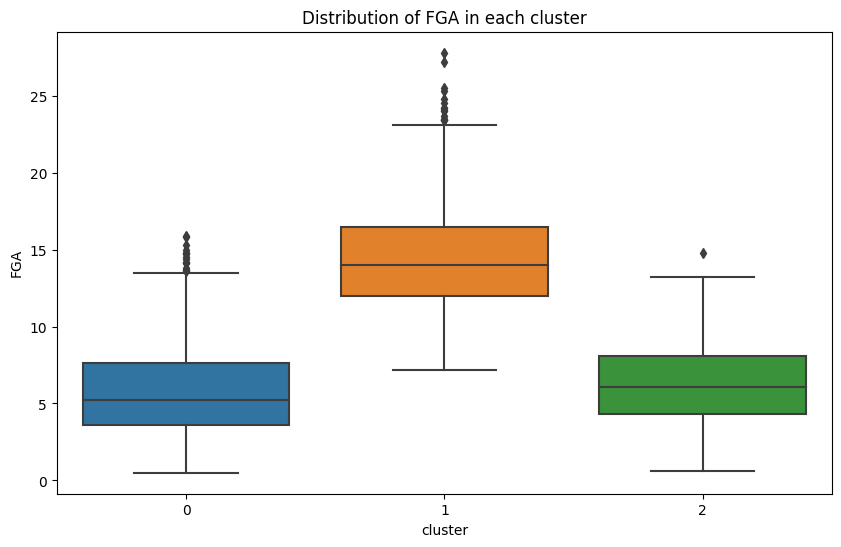

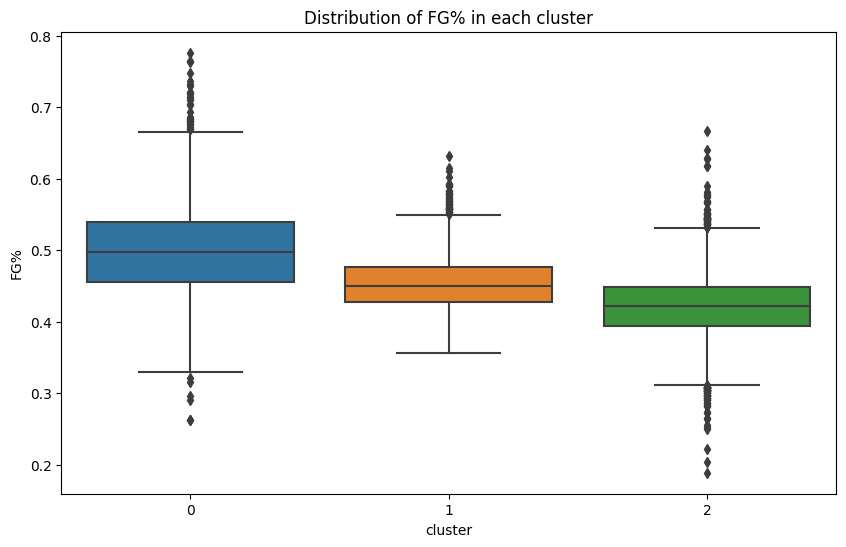

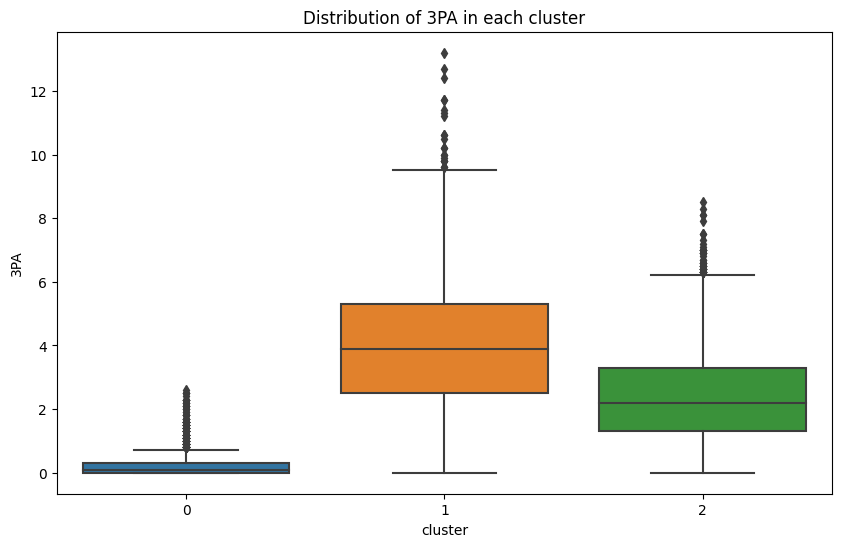

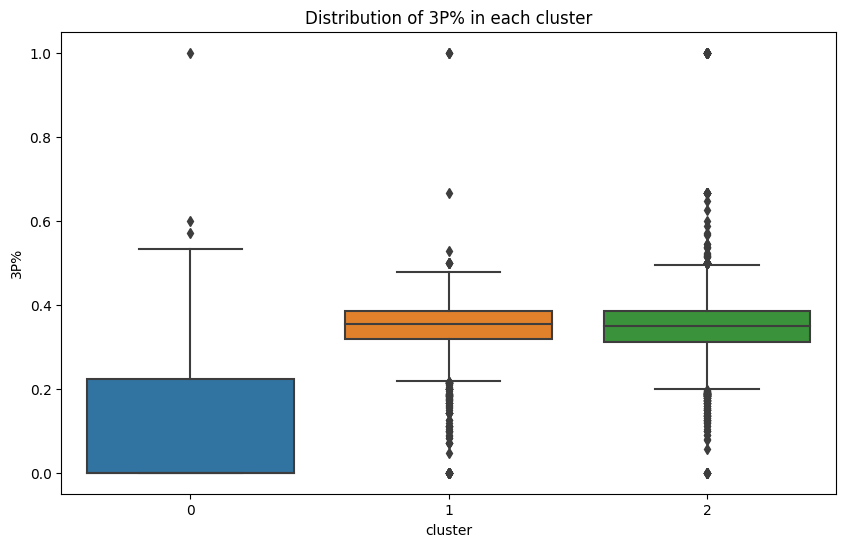

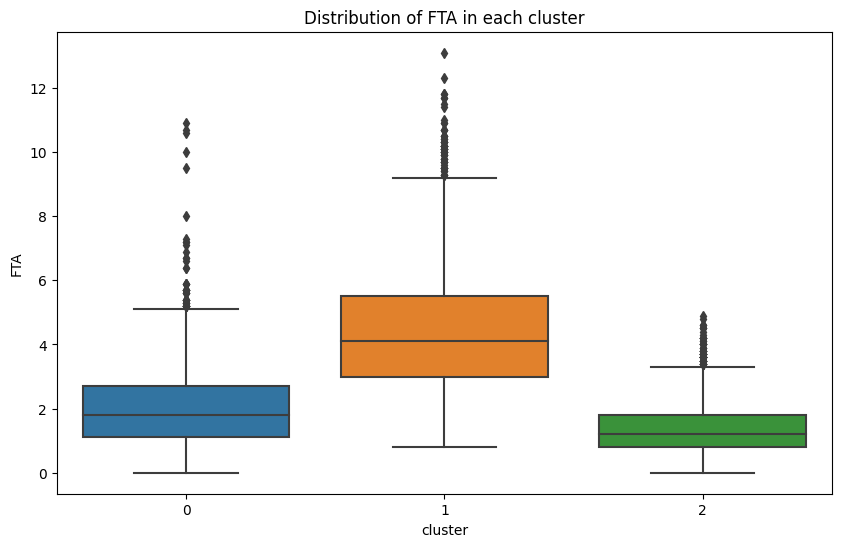

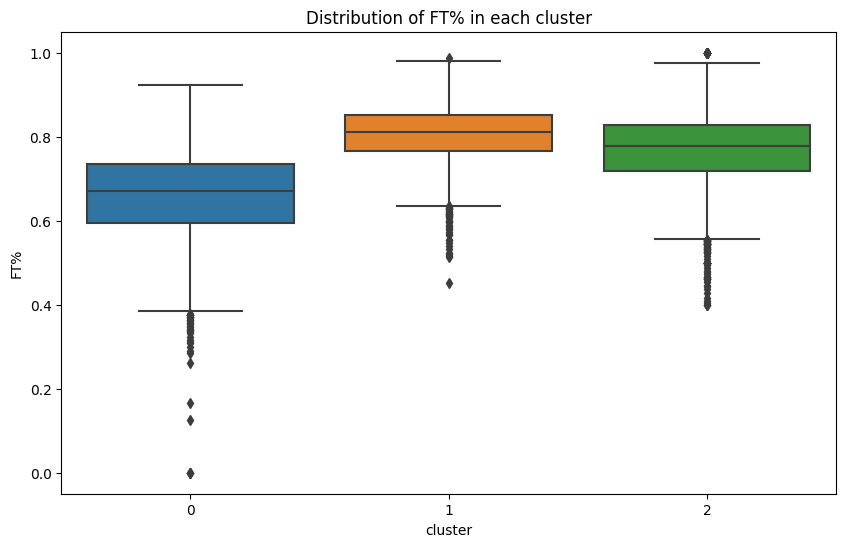

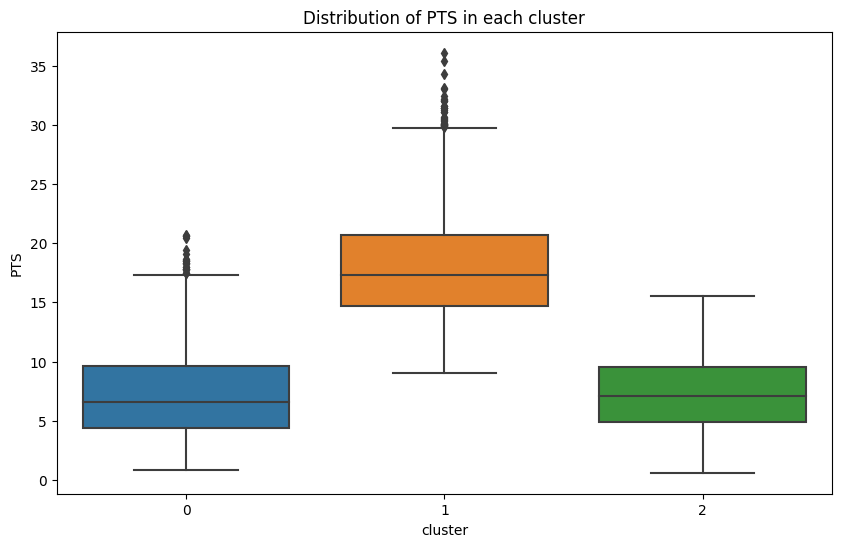

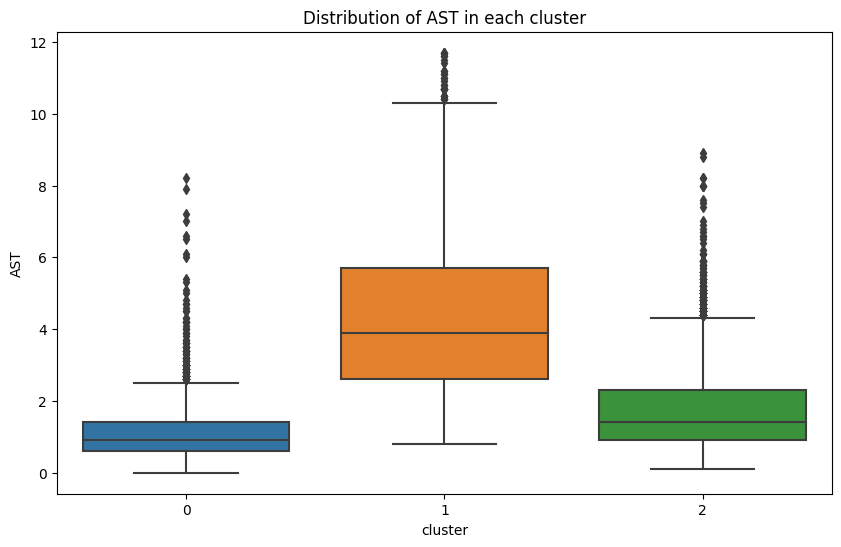

In [16]:
centroids = model.cluster_centers_

for feature in X_train.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster', y=feature, data=df_nba)
    plt.title(f"Distribution of {feature} in each cluster")
    plt.show()


In most of the offensive statistics, cluster 0 tends to have the lowest of the statistic being looked at, cluster 2 tends to be the middle, and cluster 1 tends to have the highest of the statistic. As seen in our data description notebook, a decent amount of offensive statistics are correlated with each other. Due to this, we see this pattern where it seems to be that cluster 0 seem to be more like role players, cluster 1 tends to be star players who excel offensively, and cluster 2 being average players who contribute but don't lead in offensive statistics.

# Clustering With Defensive Stats

In [17]:
from sklearn.cluster import KMeans
X_train = df_nba[["DRB", "TRB", "STL","BLK", "PF"]]
model = KMeans(n_clusters=3, random_state=4)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
model.fit(X_train_std)
clusters = model.labels_
df_nba["cluster"] = clusters
pd.crosstab(df_nba["Pos_3"], df_nba["cluster"])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cluster,0,1,2
Pos_3,,,
C,337,343,580
F,1234,1480,527
G,1961,1594,34


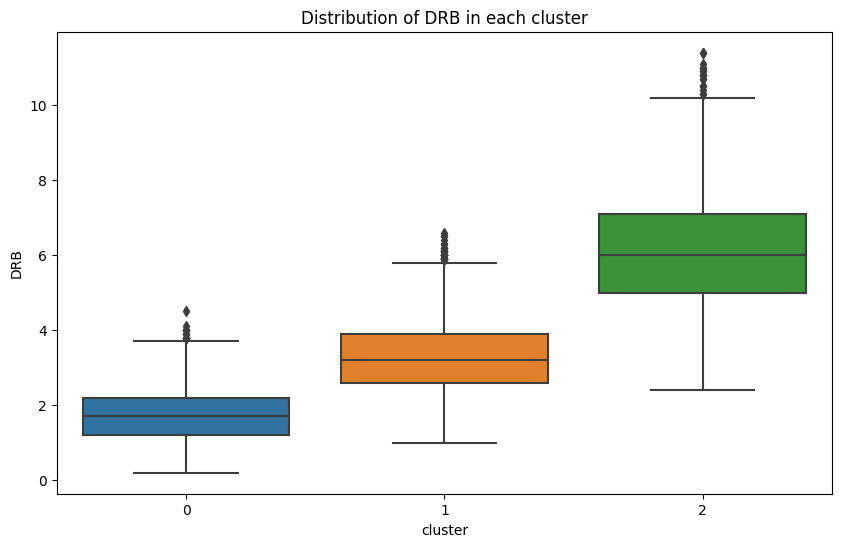

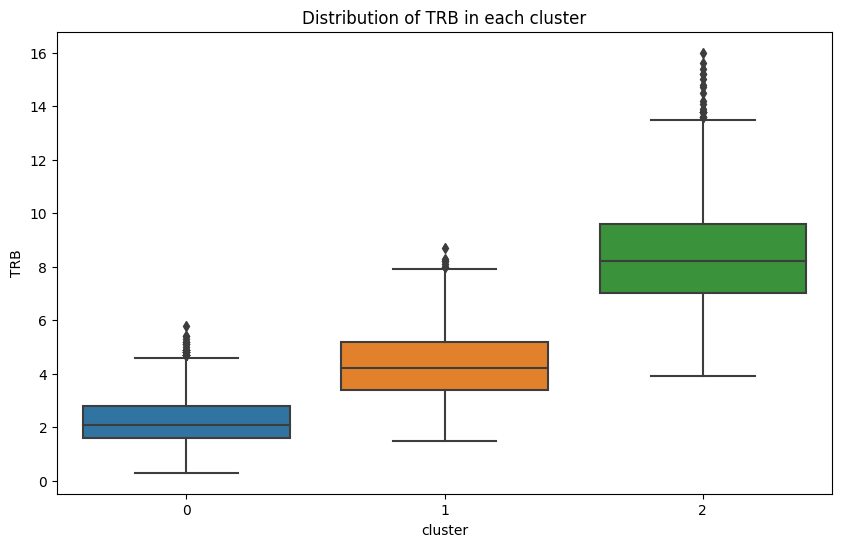

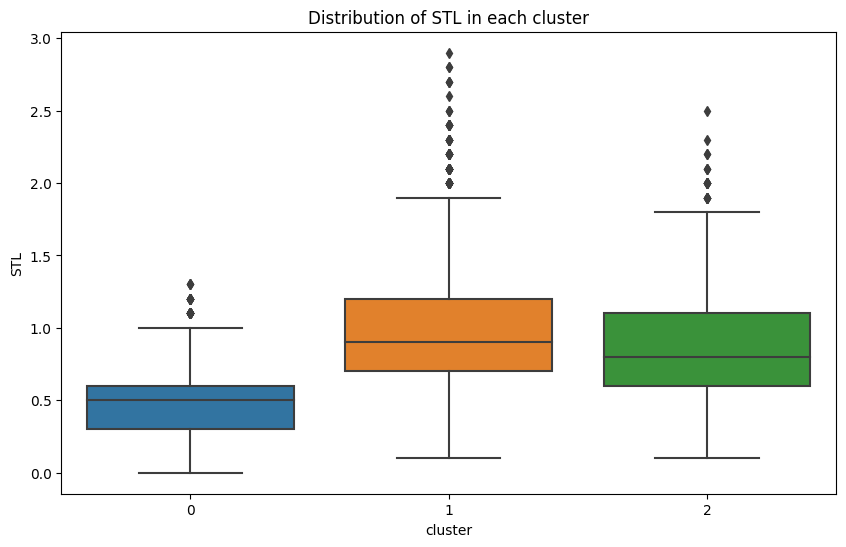

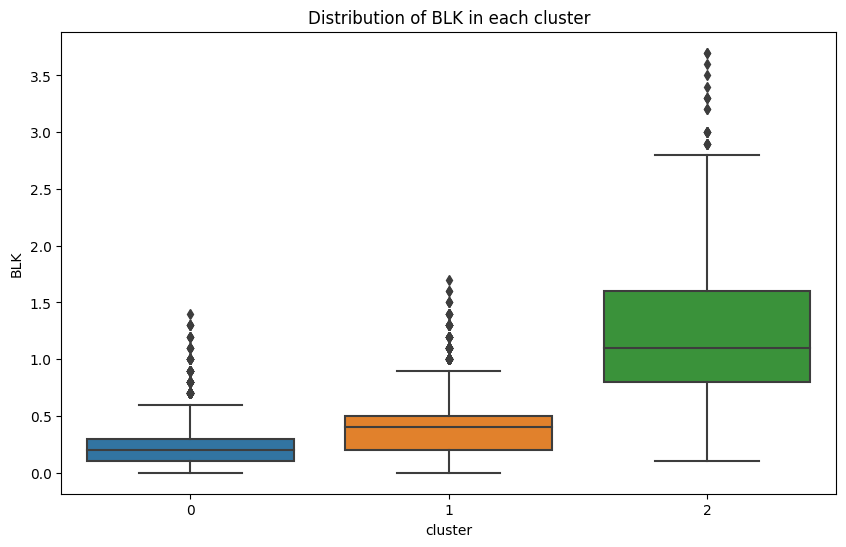

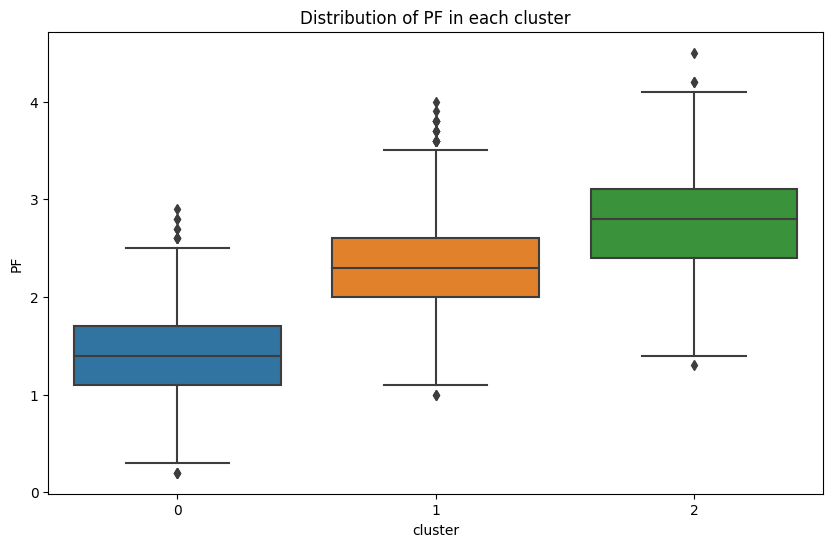

In [18]:
centroids = model.cluster_centers_

for feature in X_train.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster', y=feature, data=df_nba)
    plt.title(f"Distribution of {feature} in each cluster")
    plt.show()

Again, we see the same thing happening in most of the defensive statistics, cluster 0 tends to have the lowest of the statistic being looked at, cluster 1 tends to be the middle, and cluster 2 tends to have the highest of the statistic. This time, cluster 1 and 2 are switched, but this is aribtary and doesn't change our analysis. Again, we can explain this due to a decent amount of defensive statistics are correlated with each other. Due to this, we see this pattern where it seems to be that cluster 0 seem to have lesser roles in defensive play, cluster 1 tends to be players that contribute averagely, and cluster 2 being strong defensive minded players, relative to the other two clusters.

# Clustering With Offensive and Defensive Stats

In [19]:
from sklearn.cluster import KMeans
X_train = df_nba[["FG", "FGA", "FG%", "3P", "3PA", "3P%", "2P", "2PA", "2P%", "eFG%", "FT", "FTA", "FT%", "ORB", "DRB", "TRB", "AST", "STL","BLK", "TOV", "PF", "PTS"]]
model = KMeans(n_clusters=3, random_state=4)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
model.fit(X_train_std)
clusters = model.labels_
df_nba["cluster"] = clusters
pd.crosstab(df_nba["Pos_3"], df_nba["cluster"])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cluster,0,1,2
Pos_3,,,
C,472,745,43
F,1919,662,660
G,2296,28,1265


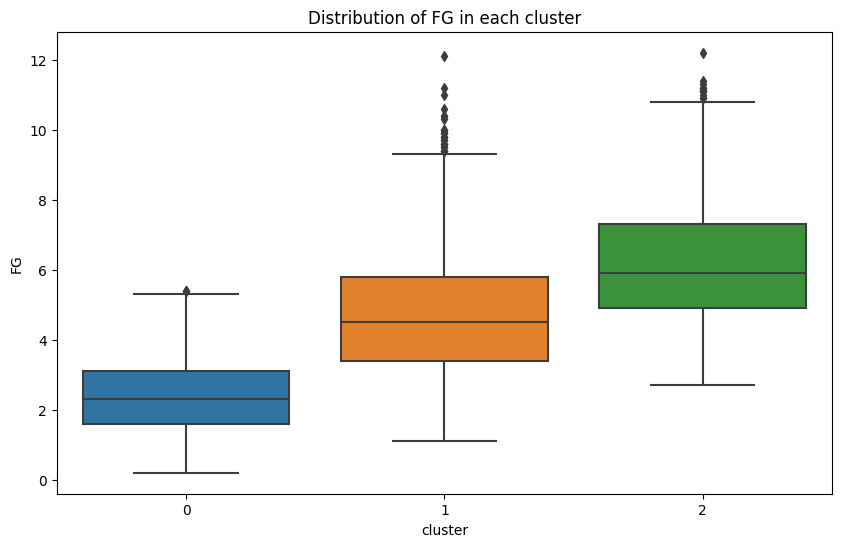

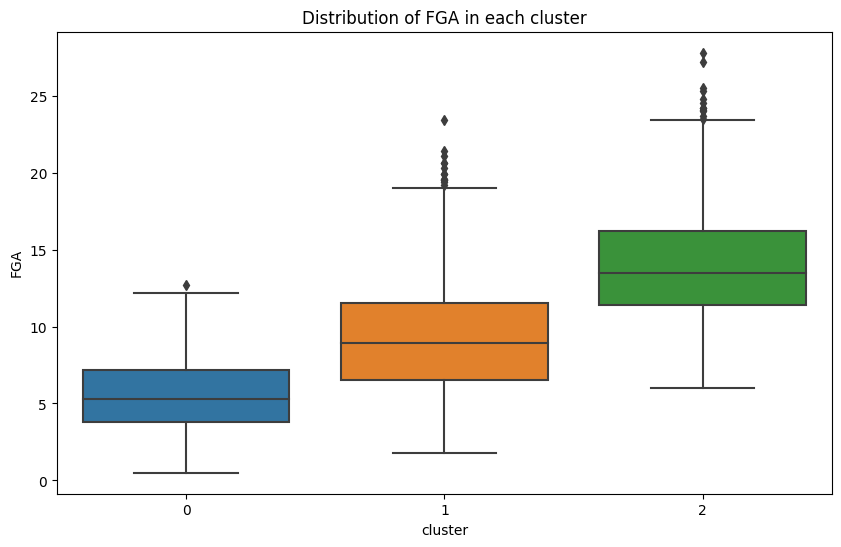

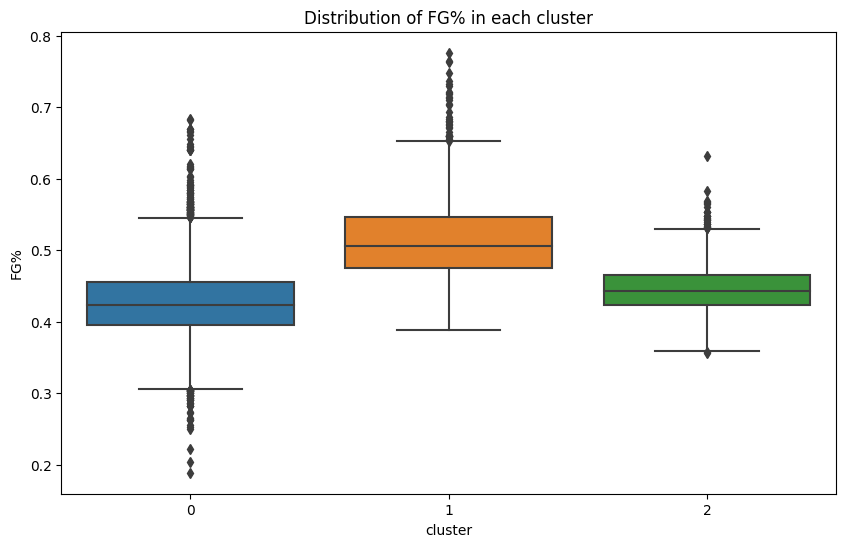

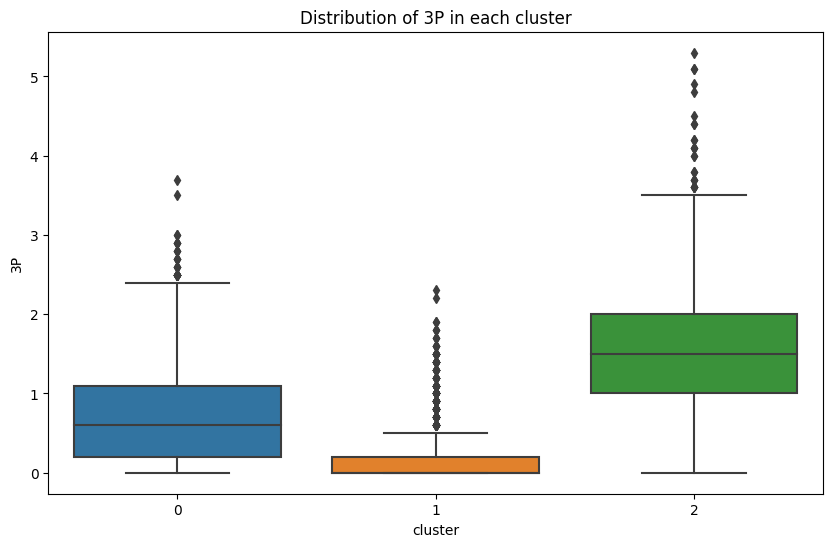

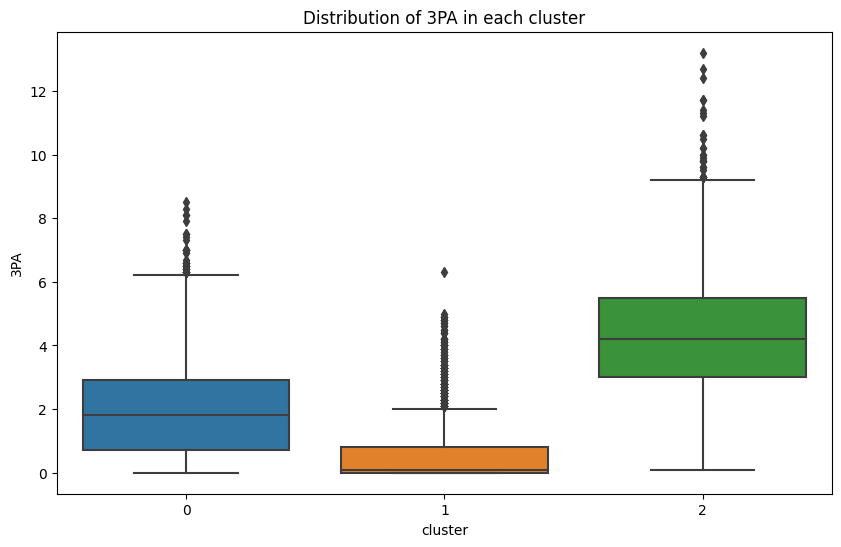

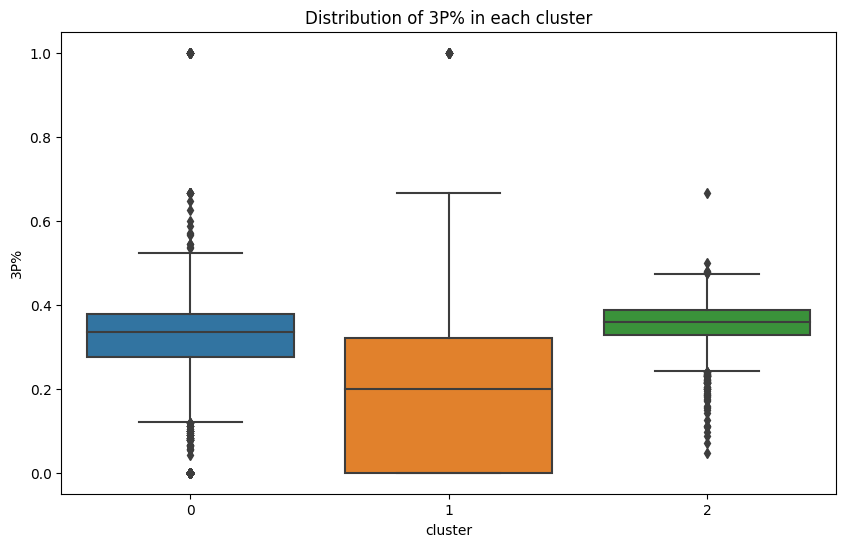

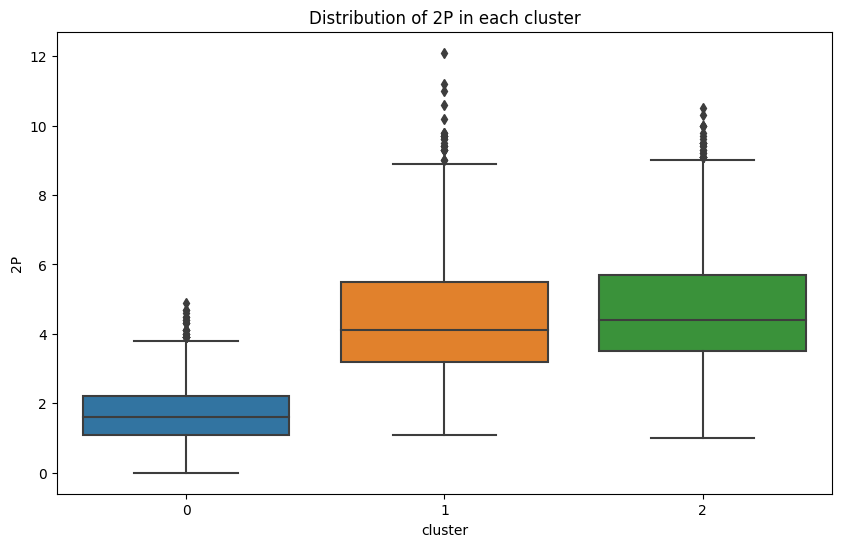

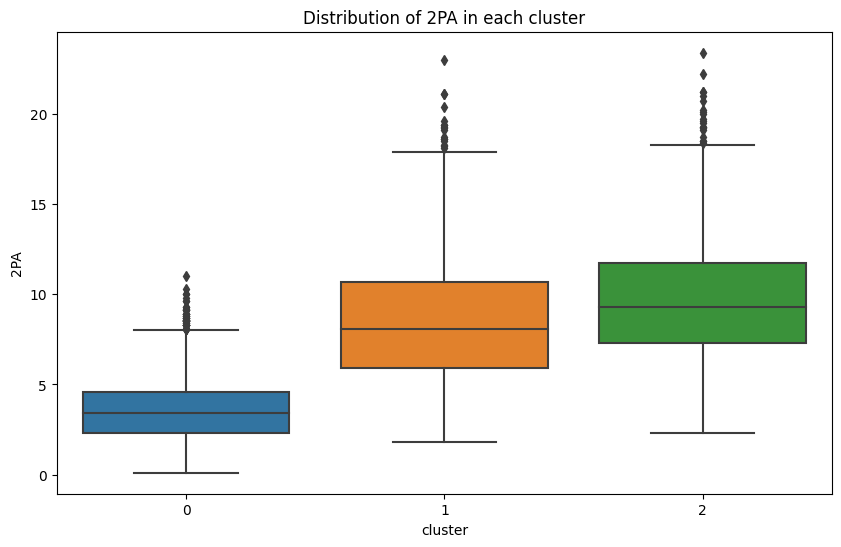

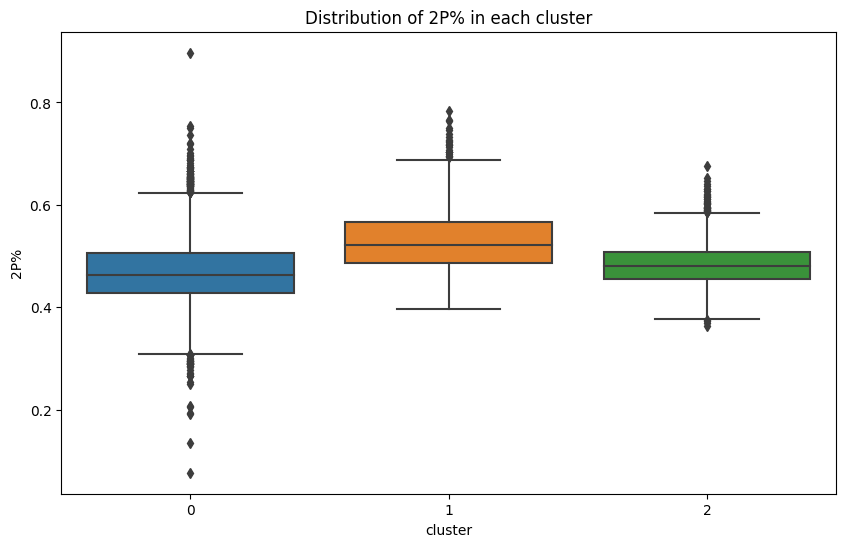

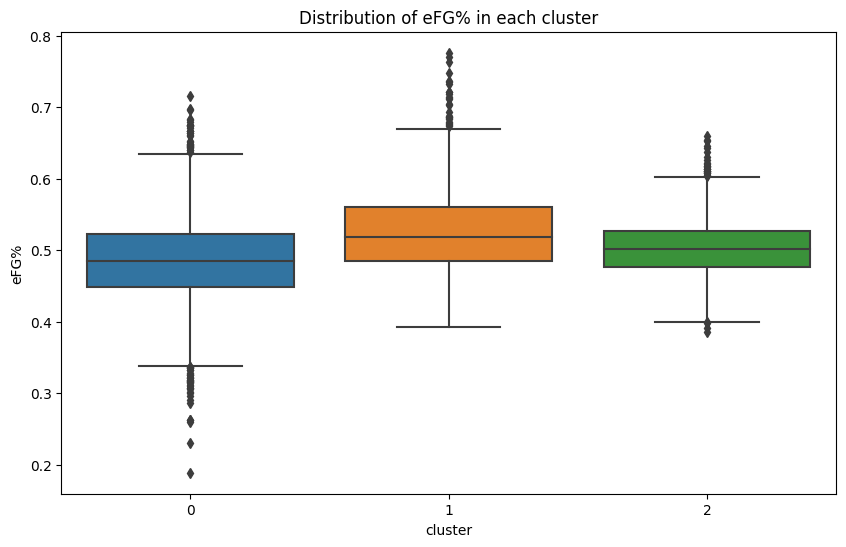

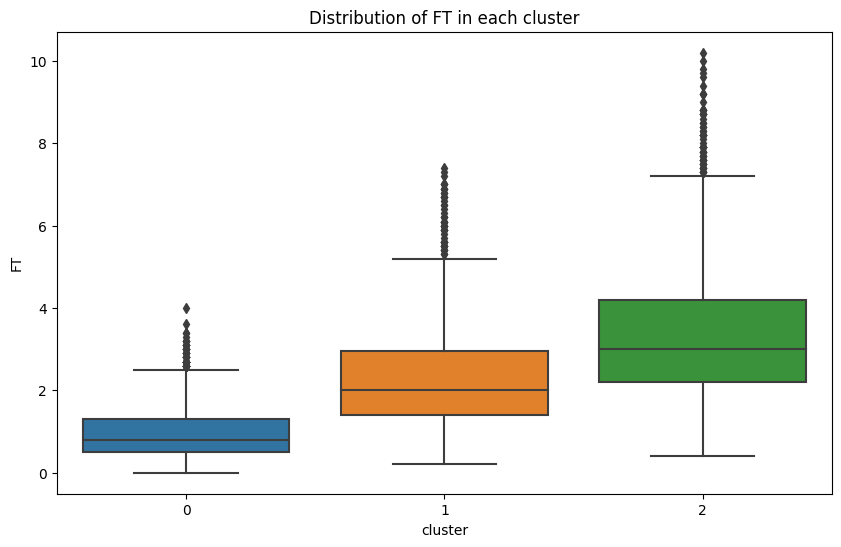

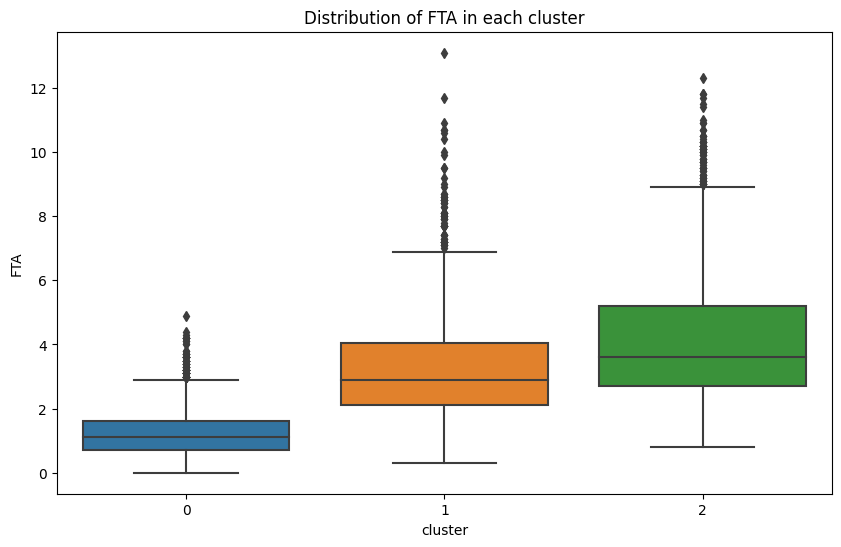

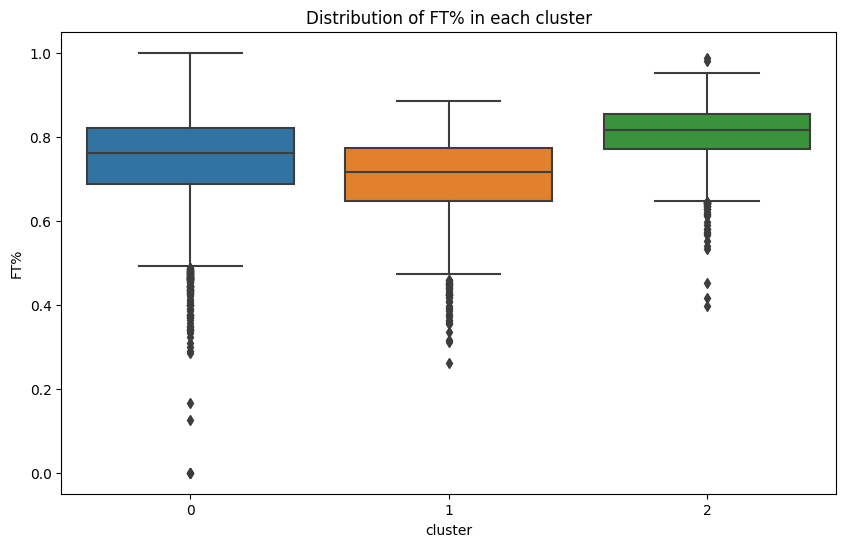

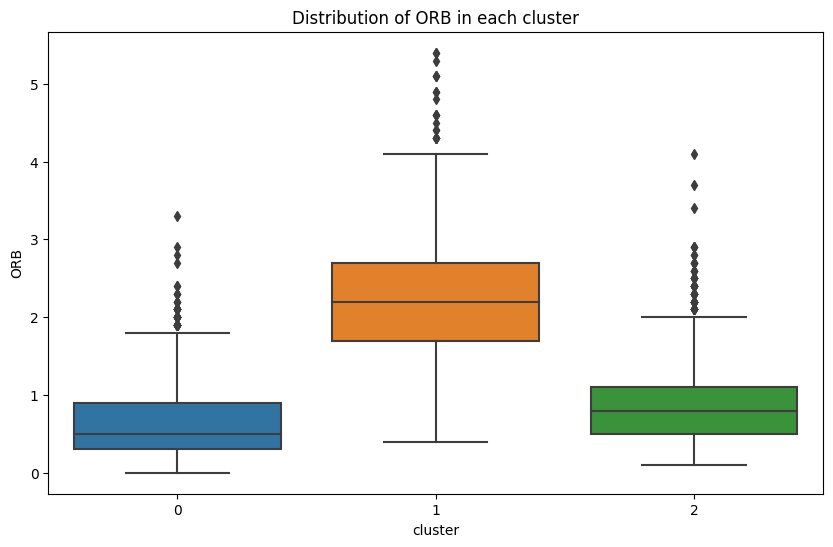

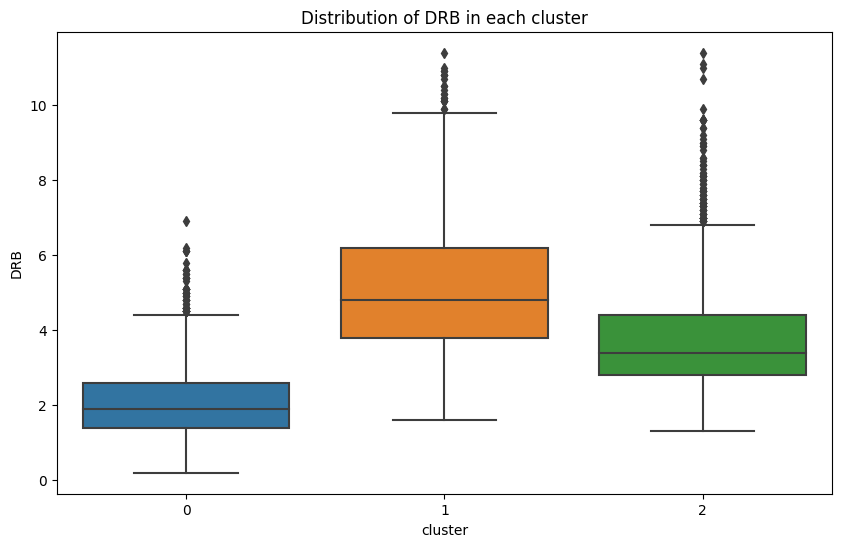

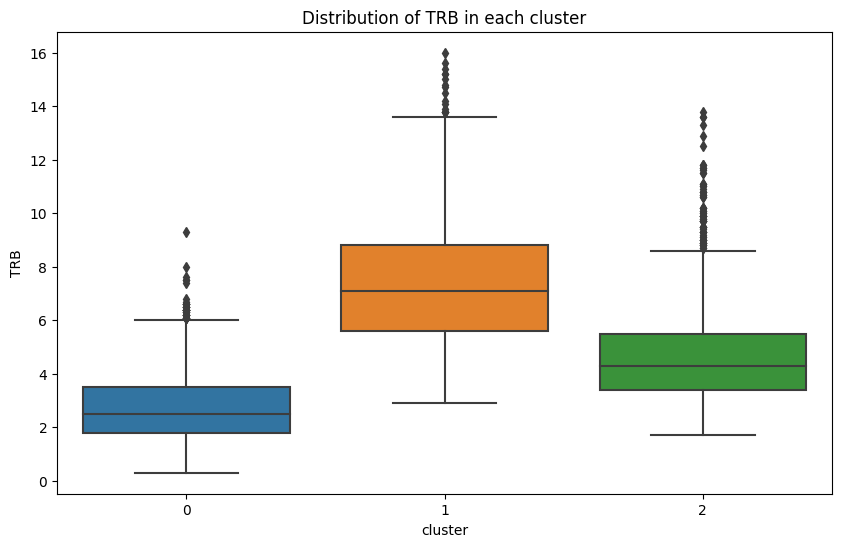

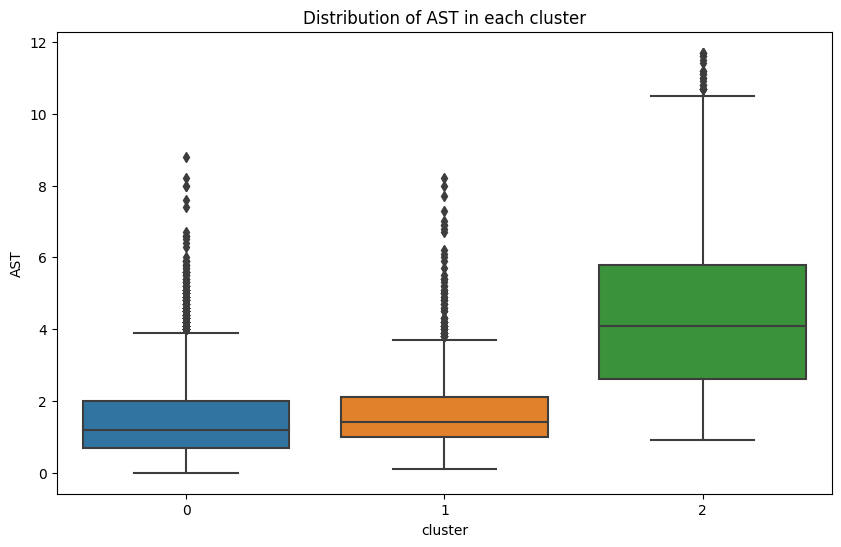

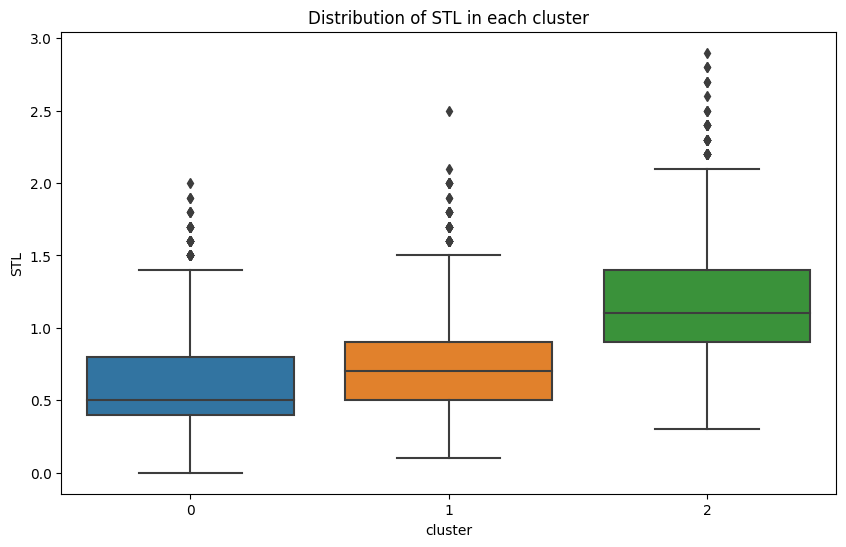

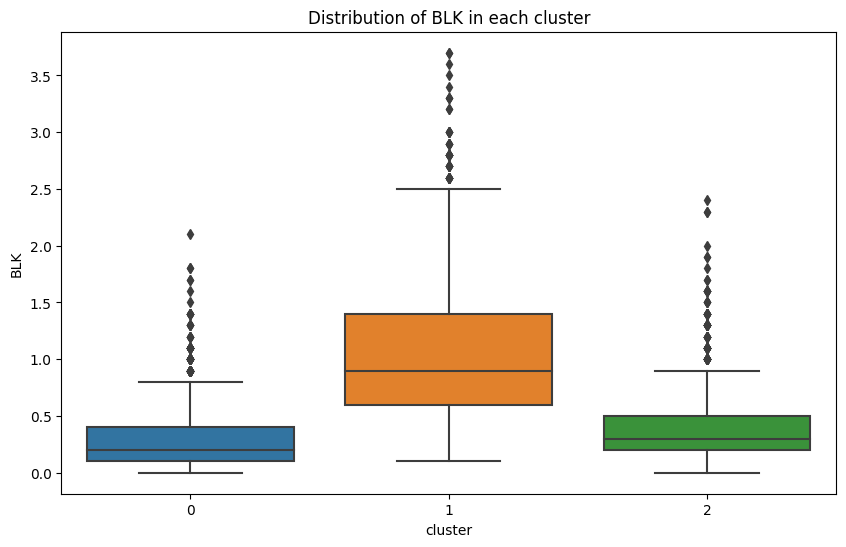

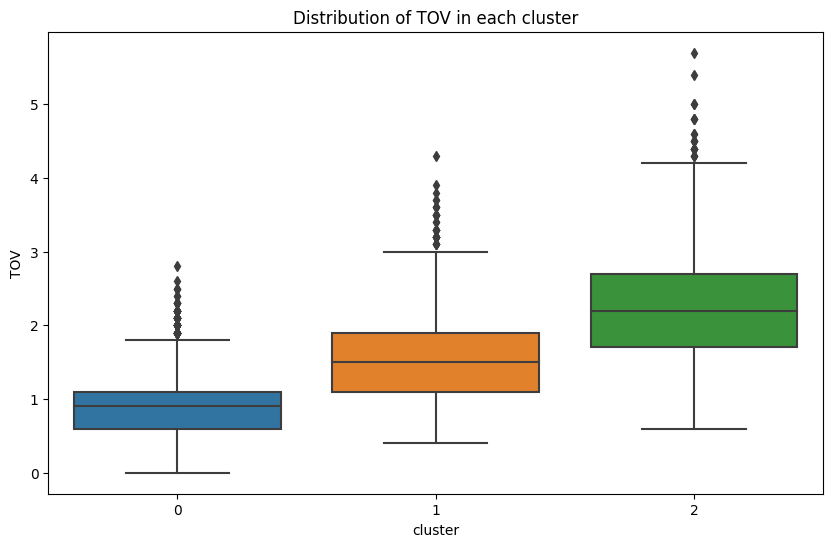

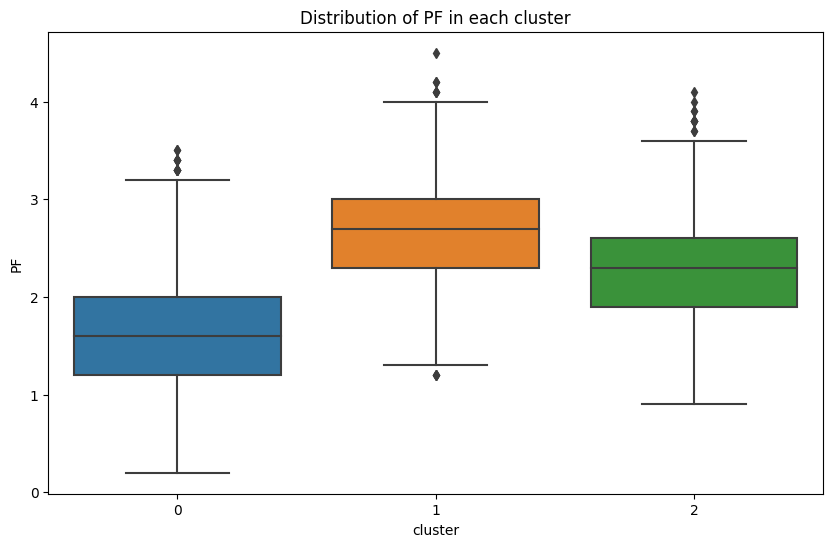

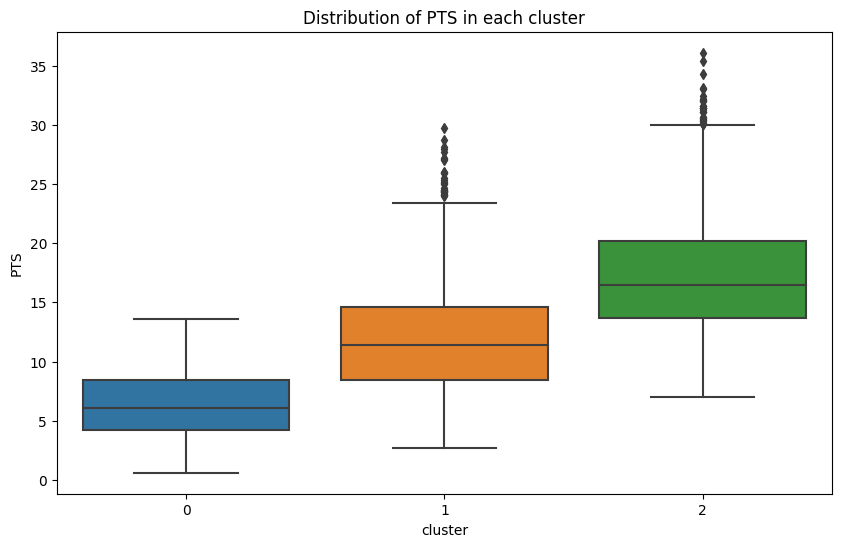

In [20]:
centroids = model.cluster_centers_

for feature in X_train.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster', y=feature, data=df_nba)
    plt.title(f"Distribution of {feature} in each cluster")
    plt.show()

This is where things get more interesting. Now, we don't see an easy pattern of increasing mean statistics for each cluster. The same patterns may hold true for offensive and defensive statistics individually, but not across all of the statistics mixed together. We can now dive deeper into the strengths and weaknesses in each cluster group.

Offensive Stats: In the first two boxplots, we see an increasing number of FG and FGA attempts going from clusters 0 to 2. From here we obviously see one way how the model choose to cluster players. In the boxplot for FG%, cluster 1 has the highest FG%, which makes sense since bigmen typically have higher field goal percentages. For the offensive statistics, it was hard to see how the model would cluster a player into cluster 0 or cluster 2 if they were a guard or forward. We now see based off the boxplots that the players in cluster 0 typically shoot the ball less and score less than players in cluster 2. In other words, it seems to be that players in cluster 2 are more offensively dominant. I don't have the statistics on the time players held the ball, but based on this and the higher assists, it's likely that you can also define these players in cluster 2 as ball dominant. My predictions for the statistics in each group were pretty good for the offensive side of things.

Defensive Stats: As for the defensive statistics, I was spot on for cluster 1. The players in cluster 1 tended to have higher rebounds, and higher blocks. However, I was shocked to find that the players in cluster 0 typically had less steals and rebounds than cluster 2. This is because I feel since cluster 0 had more forwards, this would lead to them having more steals, as they are more typically in passing lanes, have longer wingspans, and more associated with a defensive prowess than guards are. This was not the case, as players in cluster two had higher steals, blocks, and rebounds.

Based off the distinct difference in statistics between the groups, as well as a mixture of different positions in each cluster from the cross tabulation, I would be heistant to say that these clusters matched correctly to guard, forward, and center roles. Instead, through our clustering, we seem to have defined three new types of positions.